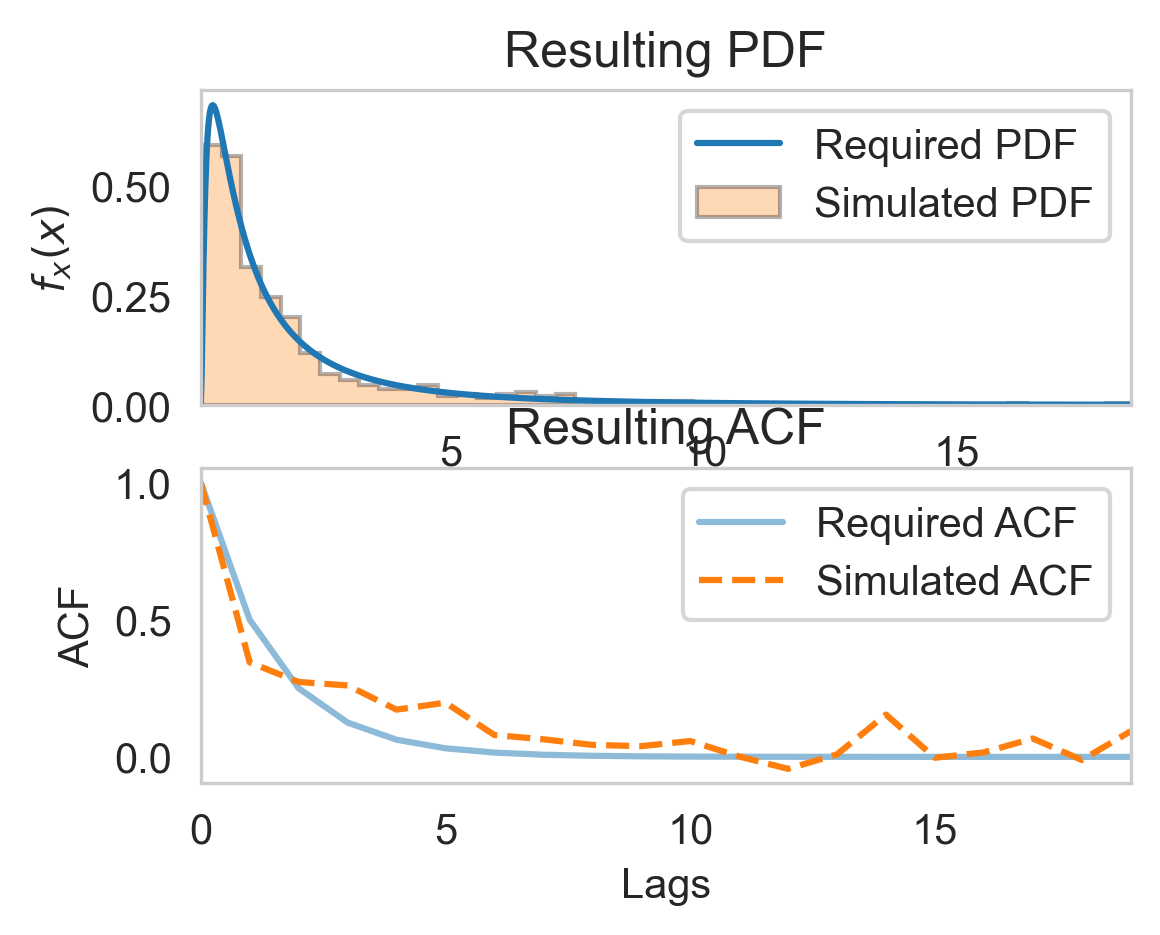

array([ 1.14031099,  1.19913757,  0.72300408,  0.52112855,  0.79067995,
        0.39426027,  0.62333493,  0.4893923 ,  0.30228031,  0.44311092,
        0.86761594,  2.34037041,  6.05090918,  2.04820602,  1.29232937,
        0.73890068,  0.43415111,  0.82674964,  0.94626549,  1.75744774,
        1.02489925,  1.48468218,  3.08022131,  0.90264739,  0.97170324,
        2.84541737,  0.84041877,  0.79606898,  0.72871222,  1.74065752,
        0.93949204,  1.24825413,  1.27573112,  1.08553665,  6.81357366,
        2.76549104,  1.19357108,  0.11221008,  0.07669475,  0.32652508,
        0.65739892,  0.3594058 ,  0.1122053 ,  0.14375105,  0.13684771,
        0.10911412,  0.16237866,  0.40160534,  0.25163065,  0.20955617,
        0.61387075,  0.8778541 ,  0.88026554,  1.87606956,  3.32157205,
        1.90167445,  1.89171755,  1.97427708,  2.17284134,  3.20771474,
        1.21256523,  3.84733535,  2.42839678,  0.50756472,  0.69259292,
        0.40354329,  0.19210022,  0.44135376,  0.73081558,  0.23

In [52]:
from generate_corr_sequence import gen_corr_sequence
import scipy.stats as st
import numpy as np

acf = 1 / (2 ** np.arange(20))

delays  = gen_corr_sequence(
    dist_obj=st.lognorm(s=1.2, loc=0.046, scale=1),
    L=500,
    target_acf=acf,
    debug=True,
)
delays

In [53]:
delays.size

500

In [54]:
acf_50 = 1 / (2 ** np.arange(5))  # 0.5 corr
acf_25 = 1 / (4 ** np.arange(5))
acf_12 = 1 / (8 ** np.arange(5))
acf_00 = np.zeros(5)
acf_00[0] = 1.0


In [55]:
acf_50

array([1.    , 0.5   , 0.25  , 0.125 , 0.0625])

In [56]:
acf_25

array([1.        , 0.25      , 0.0625    , 0.015625  , 0.00390625])

In [57]:
from collections import deque
import pandas as pd

scales = (
    0.1,
    0.2,
    0.4,
    0.8,
    1.6,
    3.2,
)
min_bound = 0.042
shape = 1.2


rows = deque()
for scale in scales:
    dist = st.lognorm(s=shape, loc=min_bound, scale=scale)
    mean, var = dist.stats()
    rows.append({
        r"$ S $": shape,
        "location": min_bound,
        "scale": scale,
        r"$\mu$": mean,
        r"$\sigma$": np.sqrt(var),
        "\num{95}\textsuperscript{th} percentile": dist.ppf(.95)
    })
    
df = pd.DataFrame(rows).set_index(["$ S $", "location", "scale"])
df

$\mu$   $\sigma$  \
$ S $ location scale                        
1.2   0.042    0.1    0.247443   0.368695   
               0.2    0.452887   0.737389   
               0.4    0.863773   1.474779   
               0.8    1.685547   2.949558   
               1.6    3.329093   5.899115   
               3.2    6.616186  11.798230   

                      \num{95}\textsuperscript{th} percentile  
$ S $ location scale                                           
1.2   0.042    0.1                                   0.761815  
               0.2                                   1.481630  
               0.4                                   2.921261  
               0.8                                   5.800522  
               1.6                                  11.559043  
               3.2                                  23.076087

In [58]:
print(
    df
    .to_latex(
        float_format="%0.2f"
    )
)

\begin{tabular}{lllrrr}
\toprule
 &  &  & $\mu$ & $\sigma$ & 
um{95}	extsuperscript{th} percentile \\
$ S $ & location & scale &  &  &  \\
\midrule
\multirow[t]{6}{*}{1.200000} & \multirow[t]{6}{*}{0.042000} & 0.100000 & 0.25 & 0.37 & 0.76 \\
 &  & 0.200000 & 0.45 & 0.74 & 1.48 \\
 &  & 0.400000 & 0.86 & 1.47 & 2.92 \\
 &  & 0.800000 & 1.69 & 2.95 & 5.80 \\
 &  & 1.600000 & 3.33 & 5.90 & 11.56 \\
 &  & 3.200000 & 6.62 & 11.80 & 23.08 \\
\cline{1-6} \cline{2-6}
\bottomrule
\end{tabular}



In [59]:
from typing import Tuple
import scipy.stats as stats

target_mean_var_s = (
    (2*0.050, 2*0.010),
    (2*0.100, 2*0.020),
    (2*0.200, 2*0.040),
    (2*0.400, 2*0.080),
    (2*0.800, 2*0.160),
    (2*1.600, 2*0.320),
)
loc = 0.046


def lognorm_with_params(loc: float | int, mean: float | int, var: float | int) -> Tuple[stats.rv_continuous, float, float]:
    sigma2 = np.log((var / np.square(mean - loc)) + 1)
    mu = np.log(mean - loc) - (sigma2 / 2)
    scale = np.exp(mu)
    s = np.sqrt(sigma2)
    return st.lognorm(loc=loc, scale=scale, s=s), scale, s


for (mean, var) in target_mean_var_s:
    dist, scale, s = lognorm_with_params(loc, mean, var)
    d_mean, d_var, *_ = dist.stats()
    print(f"PARAMS Scale: {scale} | S: {s}")
    print(f"MEAN Expected: {mean:0.02f}s | Actual {d_mean:0.02f}s.")
    print(f"VARIANCE Expected: {var:0.02f}s | Actual {d_var:0.02f}s.")
    print()


PARAMS Scale: 0.019262742222029956 | S: 1.4358351376115295
MEAN Expected: 0.10s | Actual 0.10s.
VARIANCE Expected: 0.02s | Actual 0.02s.

PARAMS Scale: 0.09395441436893014 | S: 0.9941256372246269
MEAN Expected: 0.20s | Actual 0.20s.
VARIANCE Expected: 0.04s | Actual 0.04s.

PARAMS Scale: 0.2765636681237385 | S: 0.7026462185427219
MEAN Expected: 0.40s | Actual 0.40s.
VARIANCE Expected: 0.08s | Actual 0.08s.

PARAMS Scale: 0.6660750170157892 | S: 0.4979760348629696
MEAN Expected: 0.80s | Actual 0.80s.
VARIANCE Expected: 0.16s | Actual 0.16s.

PARAMS Scale: 1.4602594752154132 | S: 0.35275518214689566
MEAN Expected: 1.60s | Actual 1.60s.
VARIANCE Expected: 0.32s | Actual 0.32s.

PARAMS Scale: 3.057188633662402 | S: 0.2497027915445451
MEAN Expected: 3.20s | Actual 3.20s.
VARIANCE Expected: 0.64s | Actual 0.64s.



In [60]:
def gamma_with_params(loc: float | int, mean: float | int, var: float | int) -> Tuple[stats.rv_continuous, float, float]:
    scale = var / (mean - loc)
    k = np.square(mean - loc) / var
    return st.gamma(a=k, loc=loc, scale=scale), scale, k

for (mean, var) in target_mean_var_s:
    dist, scale, k = gamma_with_params(loc, mean, var)
    d_mean, d_var, *_ = dist.stats()
    print(f"PARAMS Scale: {scale} | Shape: {k}")
    print(f"MEAN Expected: {mean:0.02f}s | Actual {d_mean:0.02f}s.")
    print(f"VARIANCE Expected: {var:0.02f}s | Actual {d_var:0.02f}s.")
    print()

PARAMS Scale: 0.37037037037037035 | Shape: 0.14580000000000004
MEAN Expected: 0.10s | Actual 0.10s.
VARIANCE Expected: 0.02s | Actual 0.02s.

PARAMS Scale: 0.2597402597402597 | Shape: 0.5929000000000002
MEAN Expected: 0.20s | Actual 0.20s.
VARIANCE Expected: 0.04s | Actual 0.04s.

PARAMS Scale: 0.22598870056497172 | Shape: 1.5664500000000003
MEAN Expected: 0.40s | Actual 0.40s.
VARIANCE Expected: 0.08s | Actual 0.08s.

PARAMS Scale: 0.21220159151193635 | Shape: 3.553225
MEAN Expected: 0.80s | Actual 0.80s.
VARIANCE Expected: 0.16s | Actual 0.16s.

PARAMS Scale: 0.2059202059202059 | Shape: 7.546612500000001
MEAN Expected: 1.60s | Actual 1.60s.
VARIANCE Expected: 0.32s | Actual 0.32s.

PARAMS Scale: 0.2029169308814204 | Shape: 15.543306250000002
MEAN Expected: 3.20s | Actual 3.20s.
VARIANCE Expected: 0.64s | Actual 0.64s.



Mean 0.10 Var 0.00 ACF acf12


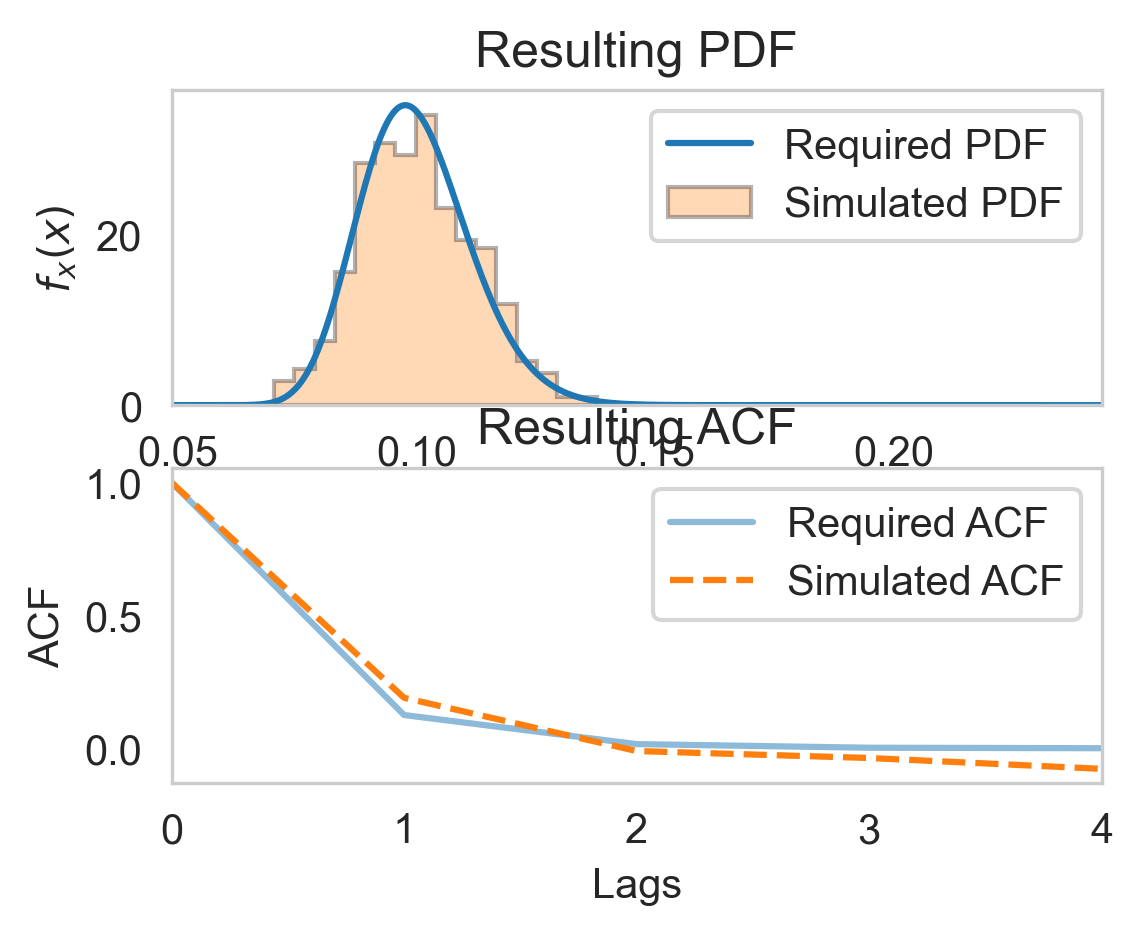

[0.10028795 0.10384856 0.09963306 0.08881923 0.10123104 0.07801785
 0.10458783 0.10904925 0.1098365  0.10672201 0.09930138 0.09481839
 0.10406022 0.10174022 0.10724172 0.09730995 0.10443044 0.09887501
 0.09603102 0.10100038 0.07772455 0.10845169 0.10437664 0.11311179
 0.11254732 0.09317246 0.0919272  0.11105282 0.10308025 0.11134476
 0.10896695 0.09485165 0.09462736 0.10176674 0.08152358 0.09079561
 0.08528201 0.10728465 0.11415845 0.11030198 0.11430396 0.12516277
 0.1086383  0.09286224 0.09955957 0.08658125 0.09980444 0.0889805
 0.11355787 0.08967188 0.11031672 0.09761021 0.08917259 0.09607072
 0.10821986 0.10368226 0.09988692 0.10246203 0.08610777 0.08753046
 0.0872929  0.11856241 0.1218666  0.09732666 0.10117433 0.11452785
 0.09439975 0.09473229 0.09420473 0.1188879  0.07394441 0.09636166
 0.09848786 0.08914316 0.13794923 0.09407197 0.09050015 0.08760714
 0.09838337 0.10967997 0.09486684 0.10328219 0.11321818 0.10305381
 0.08366654 0.11716421 0.11729887 0.08292077 0.10791919 0.09835

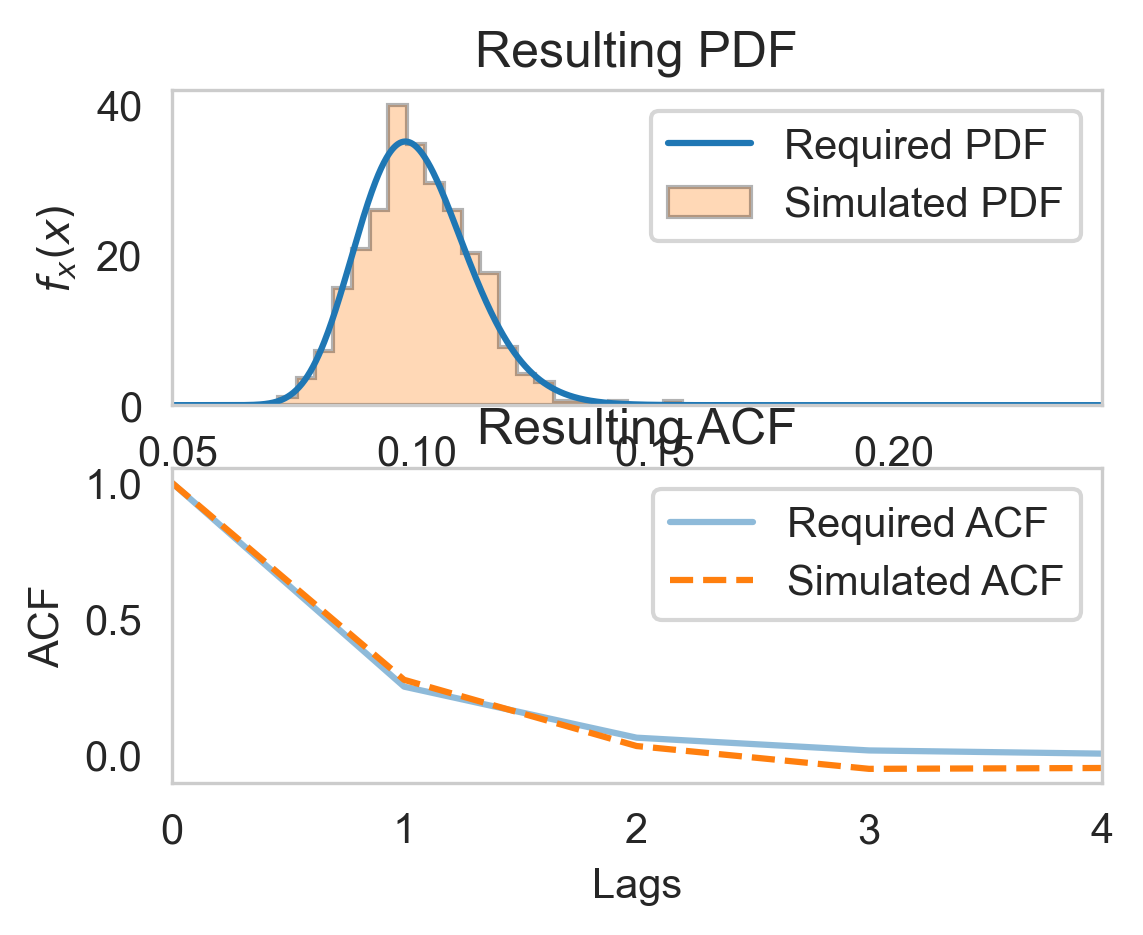

[0.10125737 0.10151841 0.10763575 0.10835918 0.09029809 0.09221347
 0.09635703 0.07657971 0.0924819  0.11158352 0.11617966 0.11538232
 0.09250824 0.10709279 0.092252   0.09365051 0.10658626 0.08629543
 0.11417977 0.10222672 0.07458665 0.0890977  0.09080753 0.08633342
 0.11144745 0.08917334 0.08082357 0.10416013 0.08879449 0.09425785
 0.09849064 0.10829872 0.11405283 0.1113828  0.10568605 0.10414083
 0.10160729 0.10386475 0.09728715 0.0826723  0.09136796 0.10614468
 0.09694642 0.12319899 0.09672157 0.11862723 0.10481811 0.0975486
 0.11483849 0.10772266 0.10064006 0.08353736 0.08388143 0.08962727
 0.11912651 0.09263421 0.11652221 0.10137266 0.1557661  0.11419566
 0.10690783 0.09682426 0.09324379 0.10288353 0.12710597 0.1168999
 0.09864964 0.08079559 0.12066119 0.1165643  0.09343646 0.08988832
 0.10490155 0.10765851 0.1034168  0.08949729 0.0785327  0.07666453
 0.09686168 0.09196906 0.10601268 0.08046324 0.11408484 0.11162354
 0.10697679 0.09782251 0.09919678 0.08878027 0.09474353 0.095780

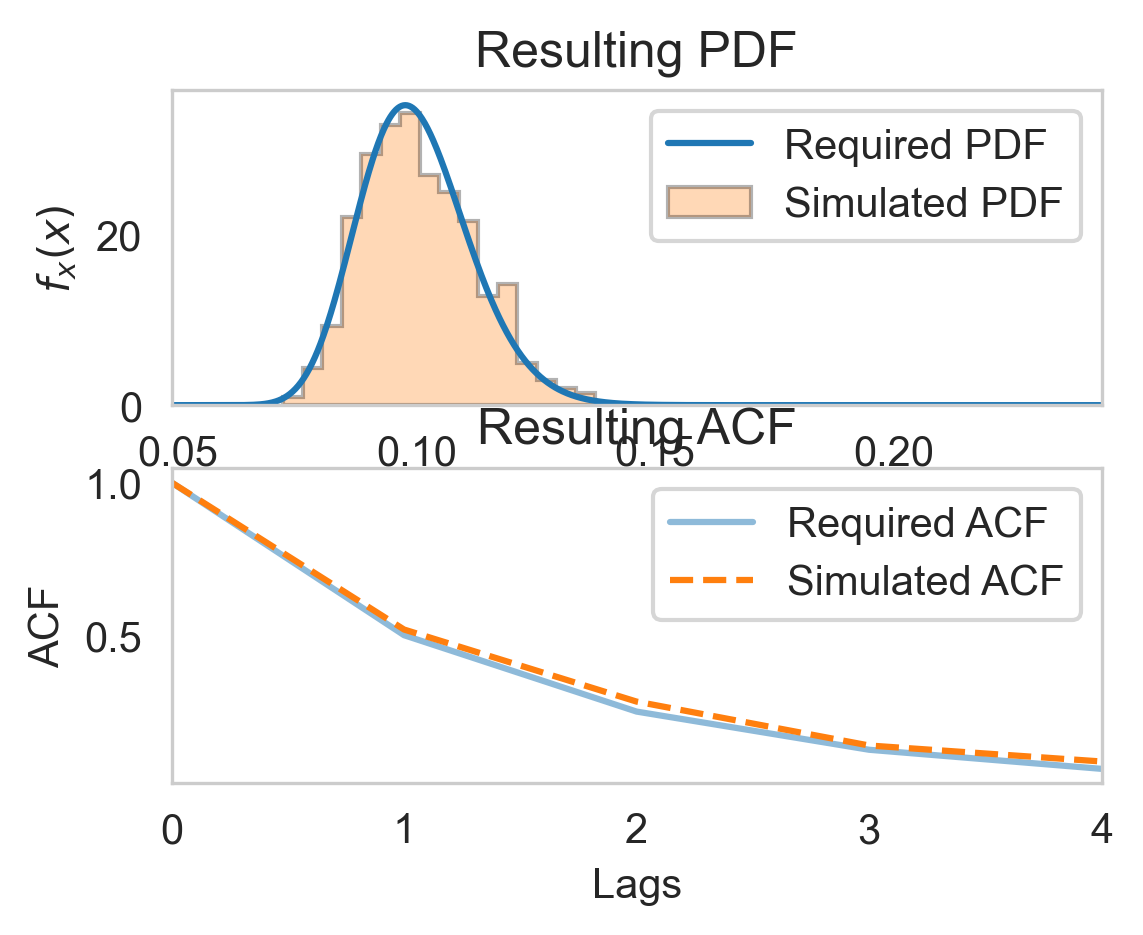

[0.09973307 0.09573094 0.09291909 0.08023951 0.08648038 0.0894168
 0.08948947 0.08121305 0.08805713 0.10138198 0.11593032 0.10064923
 0.11750495 0.11436879 0.08656606 0.09191762 0.10846333 0.08893448
 0.0935824  0.08855714 0.09319838 0.09686713 0.11777785 0.08845781
 0.09167352 0.07632945 0.08840982 0.10140217 0.10499858 0.11120626
 0.10448951 0.11499454 0.10309187 0.10047417 0.11423802 0.09971411
 0.104671   0.08684113 0.08801603 0.08746036 0.08952418 0.10458322
 0.0893227  0.0982897  0.11362165 0.10625657 0.11247608 0.08953638
 0.09987546 0.10710278 0.09234067 0.08693226 0.08780474 0.1045228
 0.09140375 0.09032363 0.09442202 0.08373191 0.09998529 0.10913734
 0.10002847 0.10199515 0.09543132 0.10154667 0.11210941 0.11190966
 0.11616652 0.12486992 0.11662649 0.10612247 0.10838998 0.09125516
 0.09338662 0.09694758 0.09958945 0.09816534 0.11064136 0.12003316
 0.09536976 0.09336504 0.11249279 0.1074696  0.11777126 0.1022612
 0.09697848 0.09177739 0.09968336 0.10205406 0.09888184 0.0955792

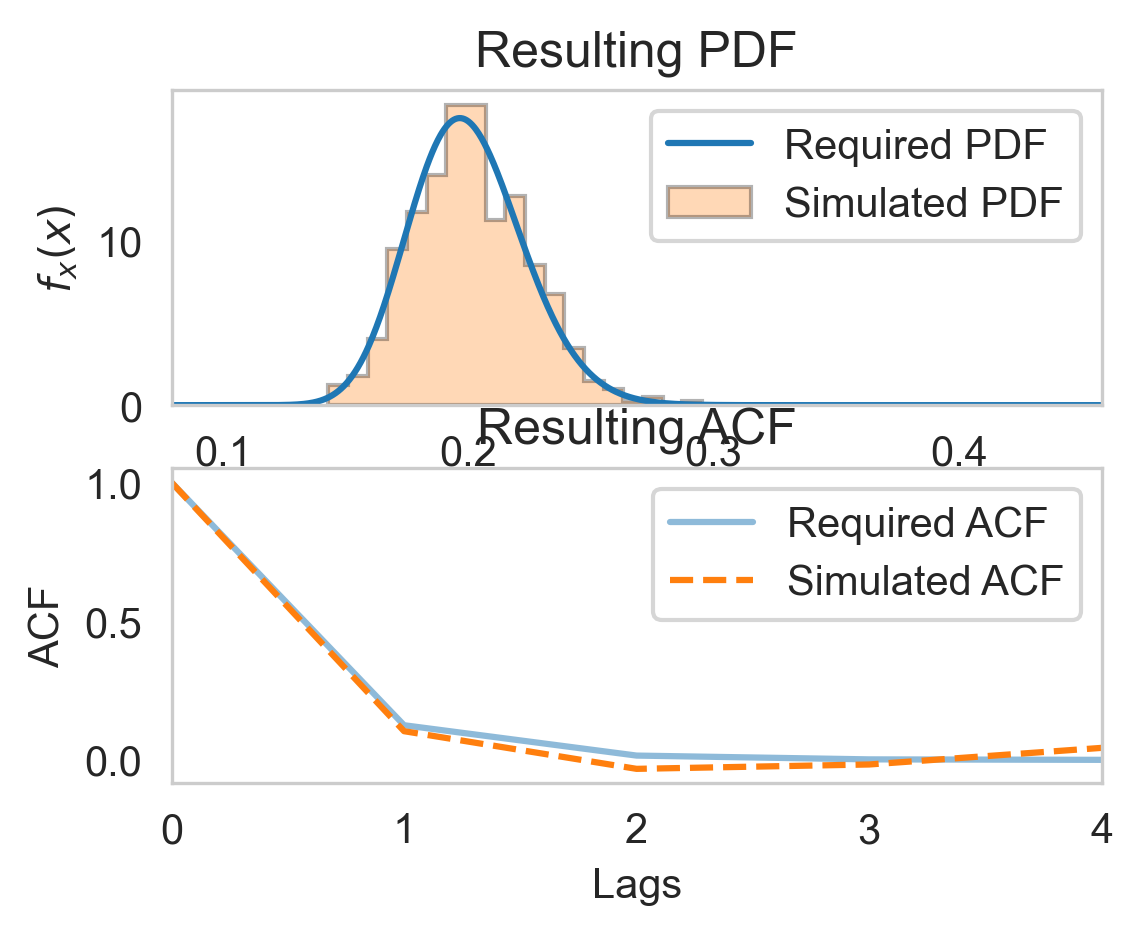

[0.2215439  0.17926907 0.2354644  0.19872237 0.29529395 0.18226685
 0.18953642 0.21462104 0.20844908 0.17961619 0.20503608 0.23496309
 0.18608606 0.21824834 0.19759485 0.20378241 0.20691903 0.23033374
 0.20149296 0.17495482 0.18028465 0.20753458 0.21708726 0.18459263
 0.20106947 0.19945921 0.18990448 0.15774672 0.19317944 0.2001467
 0.18948813 0.21330631 0.19067926 0.18505914 0.14779322 0.17896957
 0.16332045 0.20509233 0.18027879 0.23019695 0.22974544 0.20729757
 0.19159738 0.24168819 0.23424152 0.19361726 0.17494412 0.22618932
 0.19159482 0.17840686 0.18498537 0.19455038 0.21464753 0.20251968
 0.20253503 0.2038221  0.18080761 0.22353772 0.19982752 0.19242955
 0.18533013 0.17127423 0.18270905 0.21759697 0.23199609 0.21576797
 0.21084599 0.22024451 0.1907908  0.19434229 0.18570774 0.18599089
 0.21181088 0.21854985 0.23362024 0.21521893 0.20074268 0.17194848
 0.1582006  0.22000877 0.21988933 0.20274342 0.1751244  0.18306657
 0.17313083 0.194275   0.16495379 0.1918776  0.18436999 0.22014

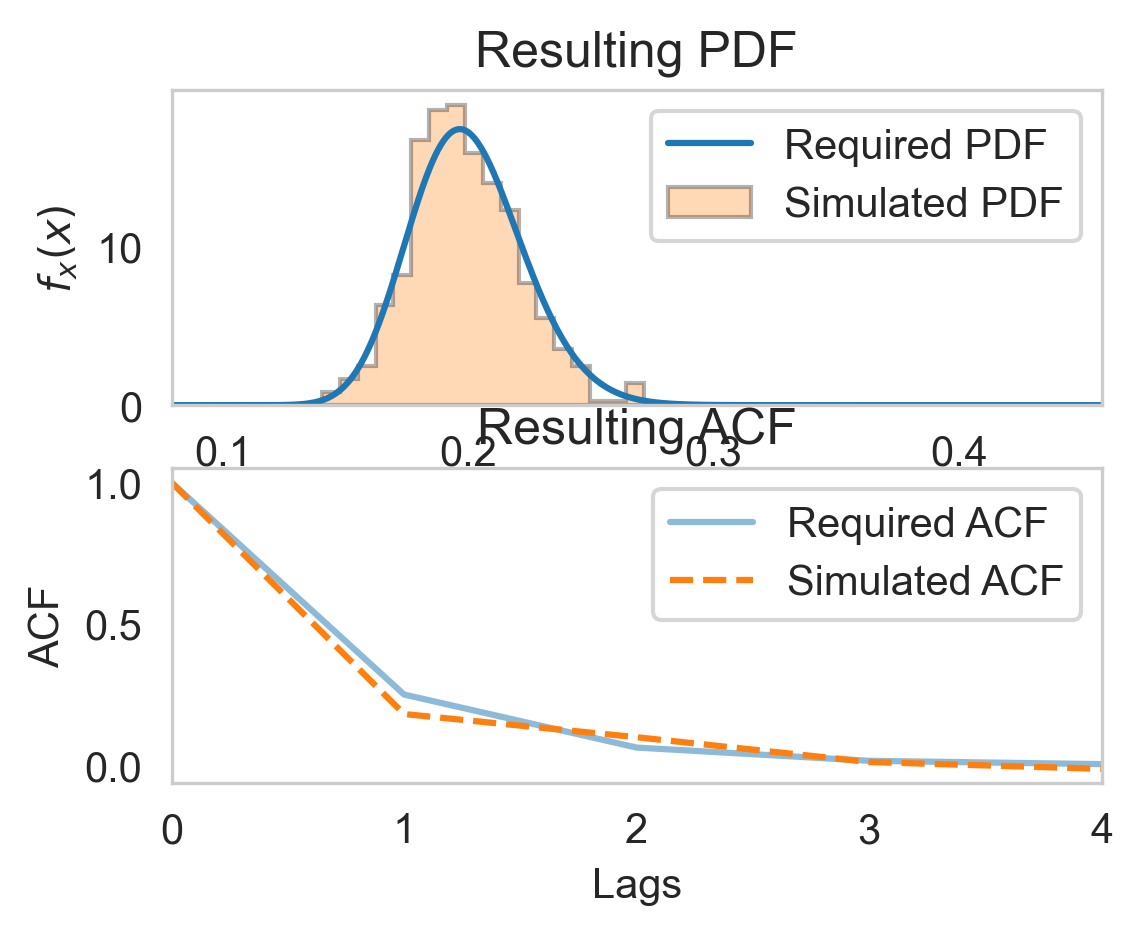

[0.20317159 0.20206996 0.2254572  0.19270393 0.19220813 0.24131082
 0.18803844 0.22693385 0.21404181 0.18701961 0.18738747 0.20201588
 0.22180607 0.18155902 0.24395726 0.18775293 0.21005272 0.21450269
 0.21428976 0.21188773 0.21572589 0.2307786  0.23512388 0.21081859
 0.17848941 0.21598034 0.20210829 0.26549317 0.18986706 0.20365683
 0.17664177 0.1763287  0.2244625  0.21637059 0.18466682 0.20911247
 0.1914871  0.18022908 0.18414491 0.21403081 0.19407684 0.19116718
 0.17372667 0.17829972 0.20751679 0.27100646 0.19224487 0.19737125
 0.20736284 0.18729464 0.19101506 0.14903468 0.21983584 0.24138706
 0.19966421 0.18311688 0.18081652 0.19981931 0.17557934 0.19043121
 0.26875511 0.19779238 0.19958574 0.22115355 0.19954818 0.20405042
 0.2381937  0.17900254 0.18078256 0.18880995 0.18094992 0.22343016
 0.19467685 0.23169433 0.21541701 0.21821066 0.20010121 0.23421854
 0.22890808 0.2020192  0.19628149 0.16329802 0.1985258  0.23278376
 0.2053287  0.20040419 0.20218454 0.19490305 0.17297808 0.1913

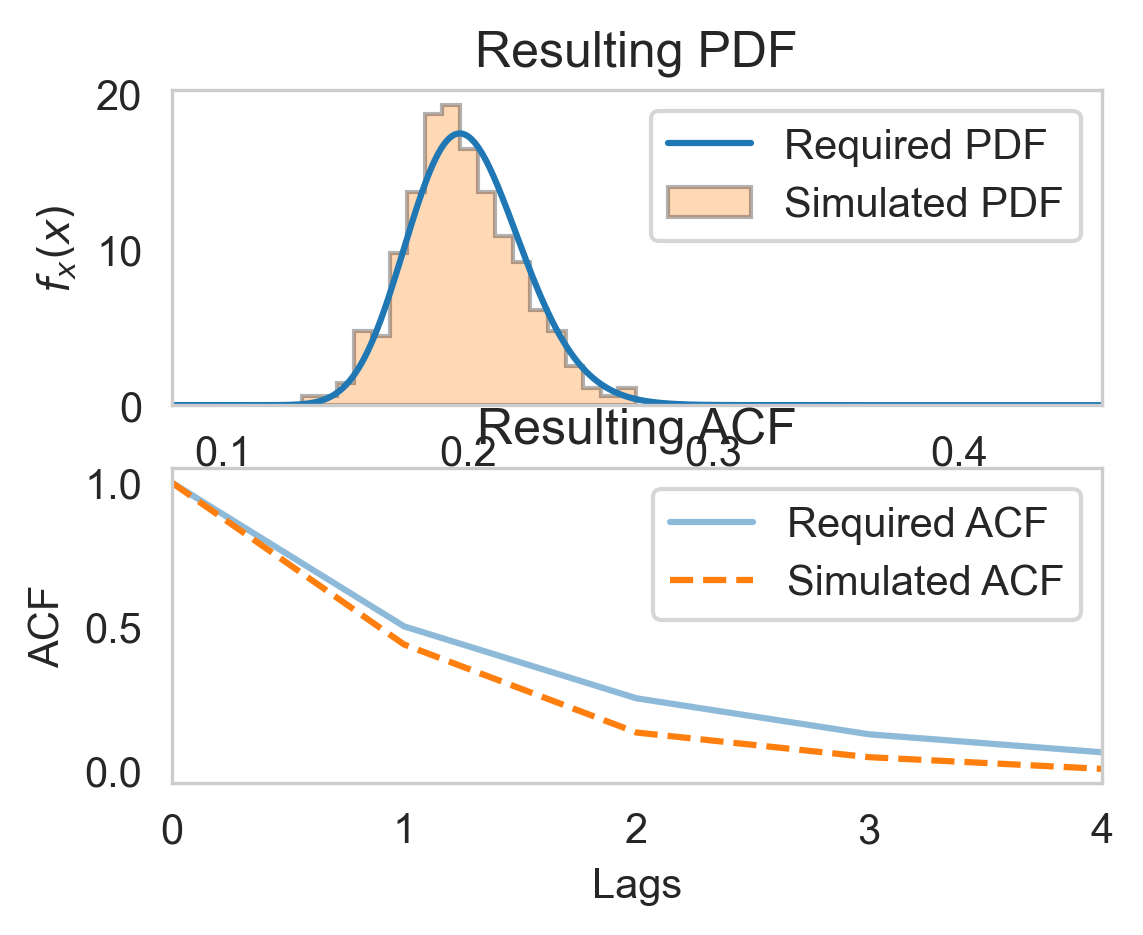

[0.19919406 0.19750103 0.19641267 0.18609568 0.18759601 0.18058515
 0.19303191 0.19780994 0.20147956 0.19676303 0.1847192  0.1737924
 0.15830311 0.15656351 0.19510898 0.16800324 0.18728881 0.19967015
 0.19644433 0.21916557 0.19248437 0.22506082 0.20299631 0.22064773
 0.23016949 0.19666779 0.22843677 0.24324799 0.16170106 0.15955301
 0.14812256 0.17253557 0.16879997 0.17210782 0.17734713 0.18284048
 0.19105042 0.14620616 0.13705183 0.15932744 0.17850141 0.15527724
 0.17410114 0.21621159 0.15980645 0.19500013 0.22084556 0.23450643
 0.21222218 0.21522128 0.21962101 0.22604143 0.21946106 0.22862135
 0.21295083 0.20950048 0.20968933 0.23748686 0.22295018 0.20940329
 0.25107047 0.20750892 0.20006922 0.17093607 0.20509811 0.19293435
 0.22781612 0.15970874 0.18299935 0.201544   0.21537905 0.18106788
 0.16824122 0.20891643 0.20439239 0.19362848 0.1801977  0.18306886
 0.21422401 0.23349747 0.20178756 0.23597747 0.19777479 0.18800396
 0.20208006 0.2220312  0.19001429 0.16410375 0.17607608 0.21565

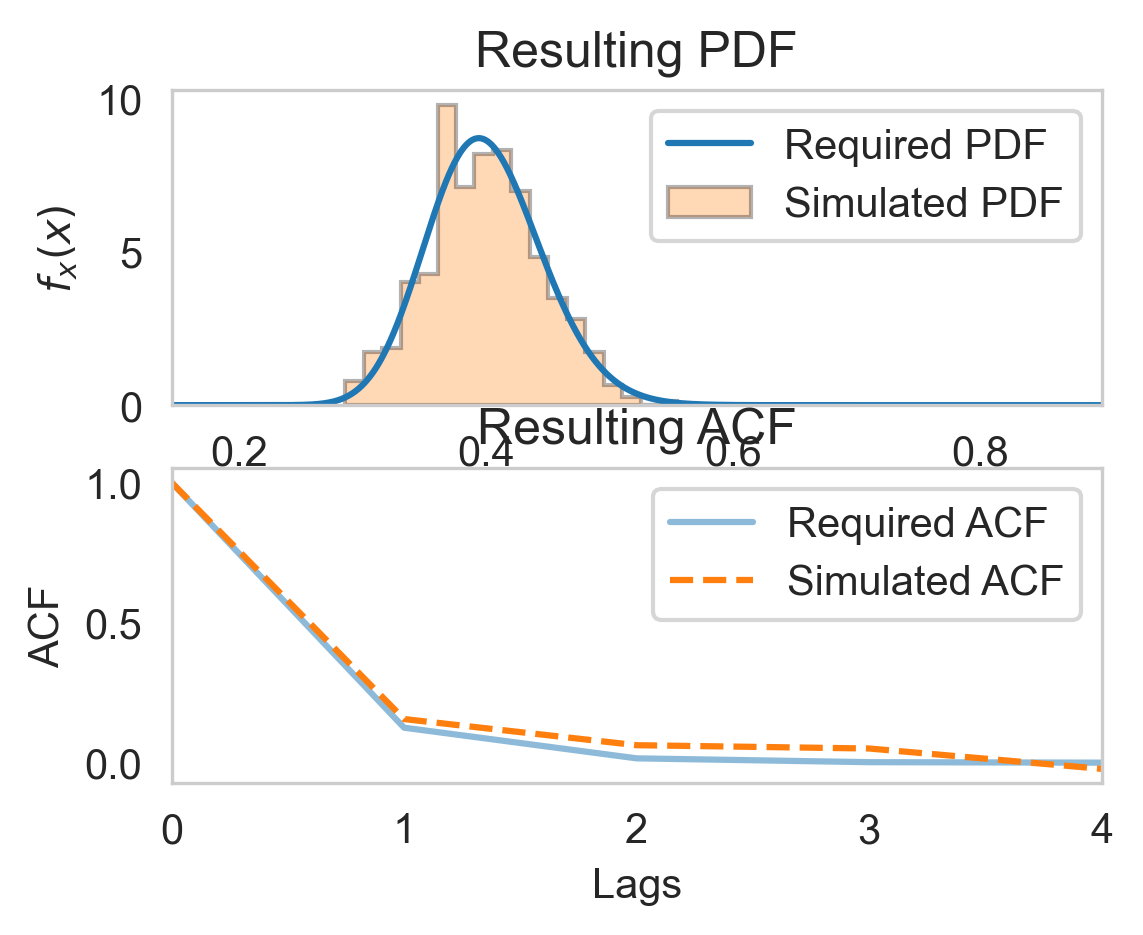

[0.39022361 0.44672104 0.388941   0.31206152 0.36076051 0.3368505
 0.40470954 0.46697699 0.32731203 0.36083959 0.4551401  0.40371339
 0.32720388 0.3584156  0.45849777 0.38875884 0.37210705 0.4197043
 0.38029121 0.4179654  0.36130973 0.36080539 0.34204226 0.47790065
 0.43792911 0.38389692 0.36479324 0.41250131 0.36857693 0.36632285
 0.43357882 0.36793675 0.39805983 0.34083337 0.34471728 0.39313885
 0.37438091 0.34661878 0.38639169 0.42629629 0.4152106  0.47137756
 0.46467991 0.41640031 0.45405296 0.35613587 0.34809836 0.36501232
 0.48101214 0.42855074 0.4068469  0.43446437 0.46005417 0.45748659
 0.30729557 0.31292704 0.3583864  0.39118895 0.37463855 0.39871262
 0.38290424 0.43662375 0.38629366 0.47378572 0.45792483 0.38756705
 0.39695943 0.39224483 0.36005644 0.45207732 0.42768843 0.38985157
 0.38507625 0.38719811 0.39892172 0.38577439 0.36453157 0.41290164
 0.40762324 0.34269314 0.37173347 0.42217345 0.40396398 0.39532582
 0.36523453 0.36518571 0.41464965 0.40267604 0.36307722 0.379583

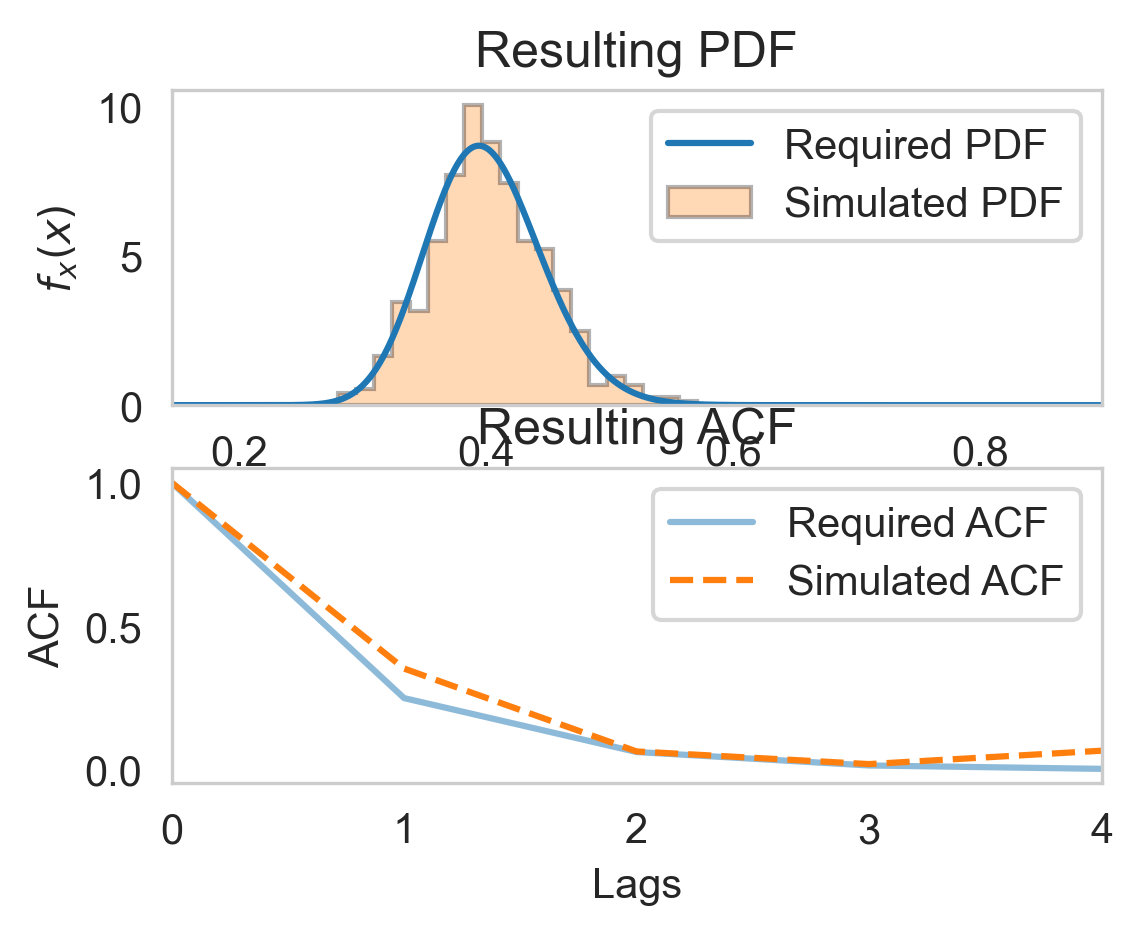

[0.39253595 0.37247977 0.36065838 0.38000896 0.3905427  0.38394675
 0.39048687 0.4001333  0.42735906 0.38684883 0.40708168 0.38684172
 0.37018387 0.3506382  0.39445208 0.37768813 0.42401391 0.28196027
 0.30806742 0.34031046 0.47399741 0.39340861 0.31632048 0.40407786
 0.45318986 0.42124625 0.45565899 0.38527083 0.52559964 0.37989399
 0.28029164 0.3842573  0.39078502 0.37792886 0.35014396 0.33733458
 0.41102848 0.3722595  0.43908292 0.42836505 0.4134484  0.43702499
 0.42872207 0.39676986 0.4623435  0.53053638 0.44911181 0.48453443
 0.38873573 0.38261559 0.50546836 0.42597274 0.33964123 0.44566768
 0.39280922 0.42953975 0.39399245 0.46522874 0.44056428 0.42983931
 0.38576576 0.44536859 0.40167374 0.39098319 0.36952422 0.42282211
 0.40451474 0.38874162 0.30332377 0.35194449 0.39591722 0.38271078
 0.36497779 0.33297713 0.37916952 0.32105733 0.34760728 0.3710313
 0.4506619  0.42057078 0.39213322 0.39044737 0.46630532 0.42005812
 0.3407987  0.34547151 0.37969747 0.44132115 0.42003559 0.40604

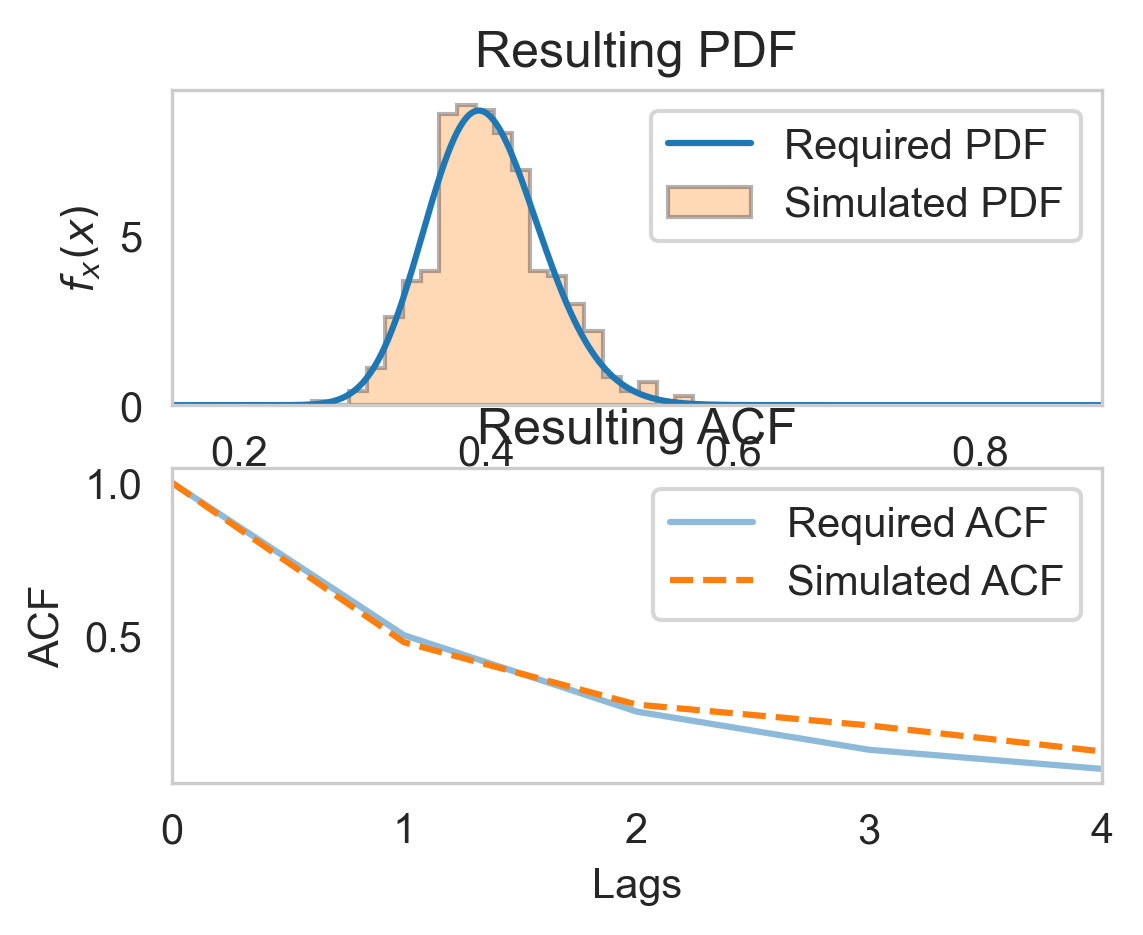

[0.41480339 0.46879838 0.37275622 0.41737508 0.42080711 0.48200501
 0.40911204 0.53065206 0.48970288 0.52690751 0.39578656 0.44446732
 0.48608104 0.49201178 0.48654741 0.40351481 0.39659743 0.37143302
 0.32232572 0.39031145 0.40593954 0.37813542 0.35033708 0.41988358
 0.42246406 0.41830015 0.33643415 0.43463289 0.36401283 0.43995956
 0.40589807 0.3841582  0.41107376 0.40327476 0.40447698 0.39925525
 0.33863323 0.34896756 0.3000372  0.37206674 0.42826933 0.36315872
 0.37531423 0.38868799 0.3646808  0.39780448 0.42115372 0.42963266
 0.47582435 0.4913429  0.4672144  0.45017992 0.4504031  0.47767286
 0.56750975 0.42580913 0.38482415 0.40932909 0.34457454 0.40035058
 0.41929527 0.4241742  0.36507303 0.48627145 0.49703536 0.49302968
 0.44105792 0.3190761  0.32790701 0.36884023 0.34102262 0.36310174
 0.42242633 0.38427744 0.40428752 0.40460418 0.42513495 0.4819325
 0.39547733 0.33479299 0.46255271 0.37050448 0.38752838 0.42321822
 0.41158929 0.3661455  0.34162678 0.35766368 0.42081583 0.38956

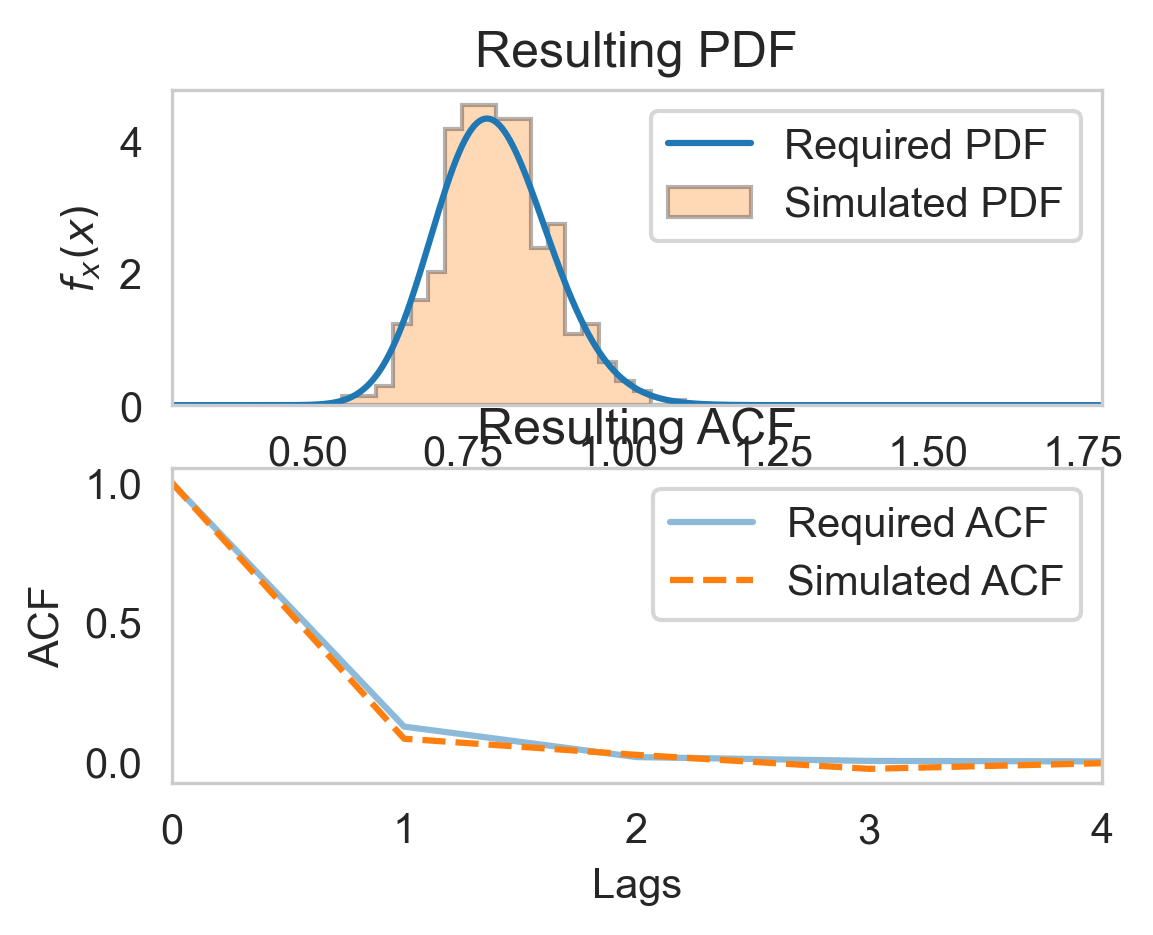

[0.7401095  0.73423799 0.7890315  0.8010925  0.68845421 0.81851689
 0.81149045 0.84535993 0.82813325 0.86827051 0.74841399 0.88609463
 0.64578242 0.94401967 0.82822662 0.82315889 0.75122068 0.73922299
 0.71704692 0.90561729 0.86523945 0.81703637 0.81592819 1.02084519
 0.89597675 0.76727402 0.66809471 0.8683703  0.9613082  0.92602918
 0.87111432 0.74376363 0.82306528 0.8270216  0.79945375 0.78528473
 0.77734403 0.81213944 0.83178247 0.81542627 0.80842294 0.97037714
 0.7113301  0.73631506 0.8041109  0.73439366 0.75368857 0.90787752
 0.75296766 0.84134601 0.80014582 0.9309972  0.8201438  0.90585148
 0.75520342 0.63700624 0.70565489 0.75133569 0.89376922 0.66179028
 0.95722059 0.74462089 0.7854922  0.89779689 0.79188003 0.76722507
 0.67942813 0.73627851 0.81233232 0.86911653 0.82381151 0.86925071
 0.99846112 0.71591864 0.8551373  0.79448371 0.86807224 0.87120474
 0.92729643 0.84804331 0.77182467 0.71488988 0.71520229 0.81272694
 0.63832856 0.85325891 0.82508116 0.83227224 0.81698746 0.7760

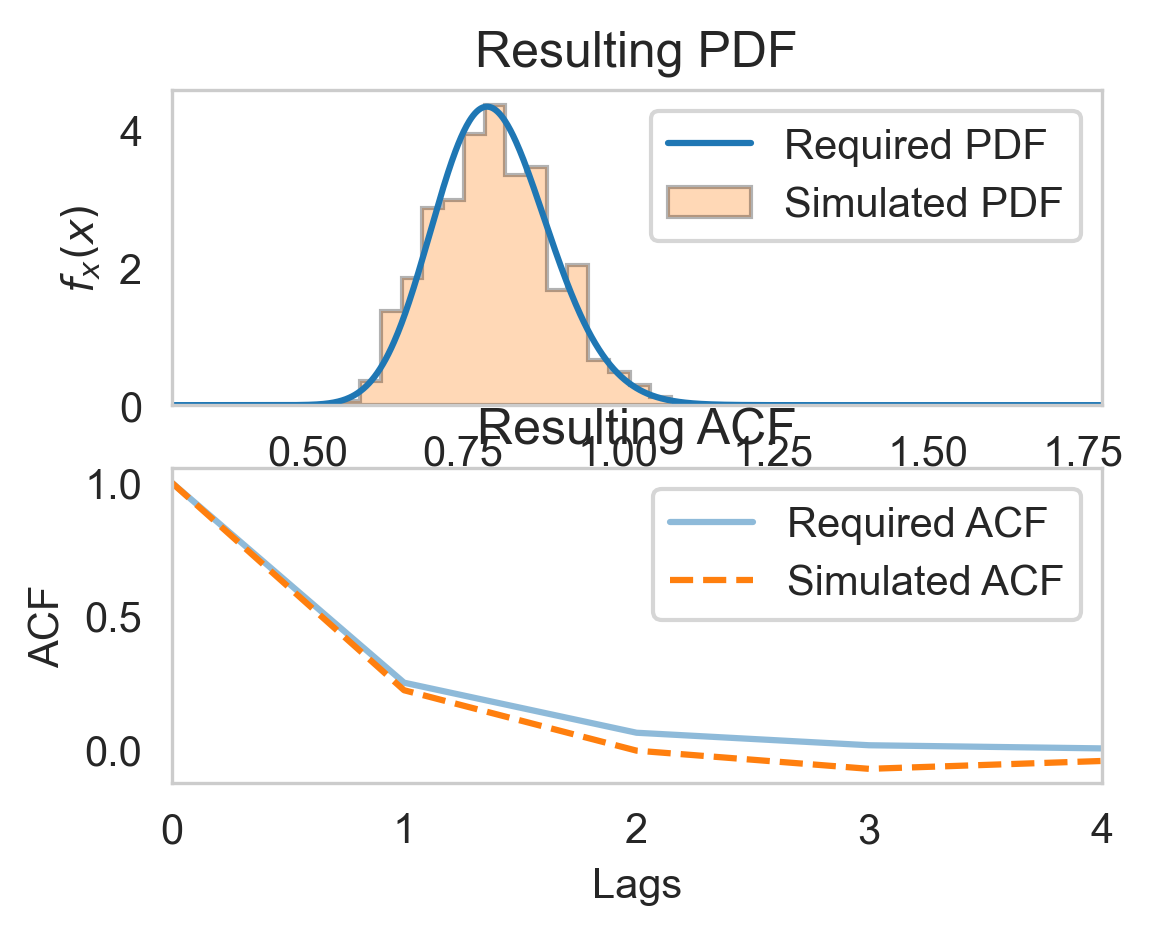

[0.65806339 0.82930333 0.72776289 0.79107469 0.64829832 0.87312964
 0.72636748 0.9410907  0.82310088 0.74238587 0.80398141 0.83032603
 0.85594581 0.69102832 0.81137432 0.81738738 0.90188277 0.78387202
 0.96100464 0.71565488 0.7034659  0.58634431 0.66099542 0.91240404
 0.94524592 0.92939138 0.81596606 0.70983612 0.75240568 0.73778244
 0.81900336 0.98936557 0.94028509 0.87236206 0.75965108 0.91024748
 0.95786394 0.68650615 0.74453    0.85193185 0.75331077 0.81079632
 0.93203399 0.94572366 0.75659179 0.81644056 0.80176339 0.65253808
 0.7436691  0.8064442  0.80341735 0.92687642 0.86035045 0.94271494
 0.92921633 0.99096693 0.84050152 0.85053388 1.08565685 0.84689105
 0.91216198 0.74089574 0.80398457 0.80375145 0.84225891 0.79074397
 0.84224051 0.76654416 0.77330874 0.83076757 0.74624064 0.71557523
 0.68731    0.81110766 0.89258951 0.76285452 0.74900136 0.82155973
 0.86602348 0.84756188 0.91625811 0.6925475  0.87433057 0.85168489
 0.69012223 0.79209151 0.80523837 0.77450988 0.66857803 0.7952

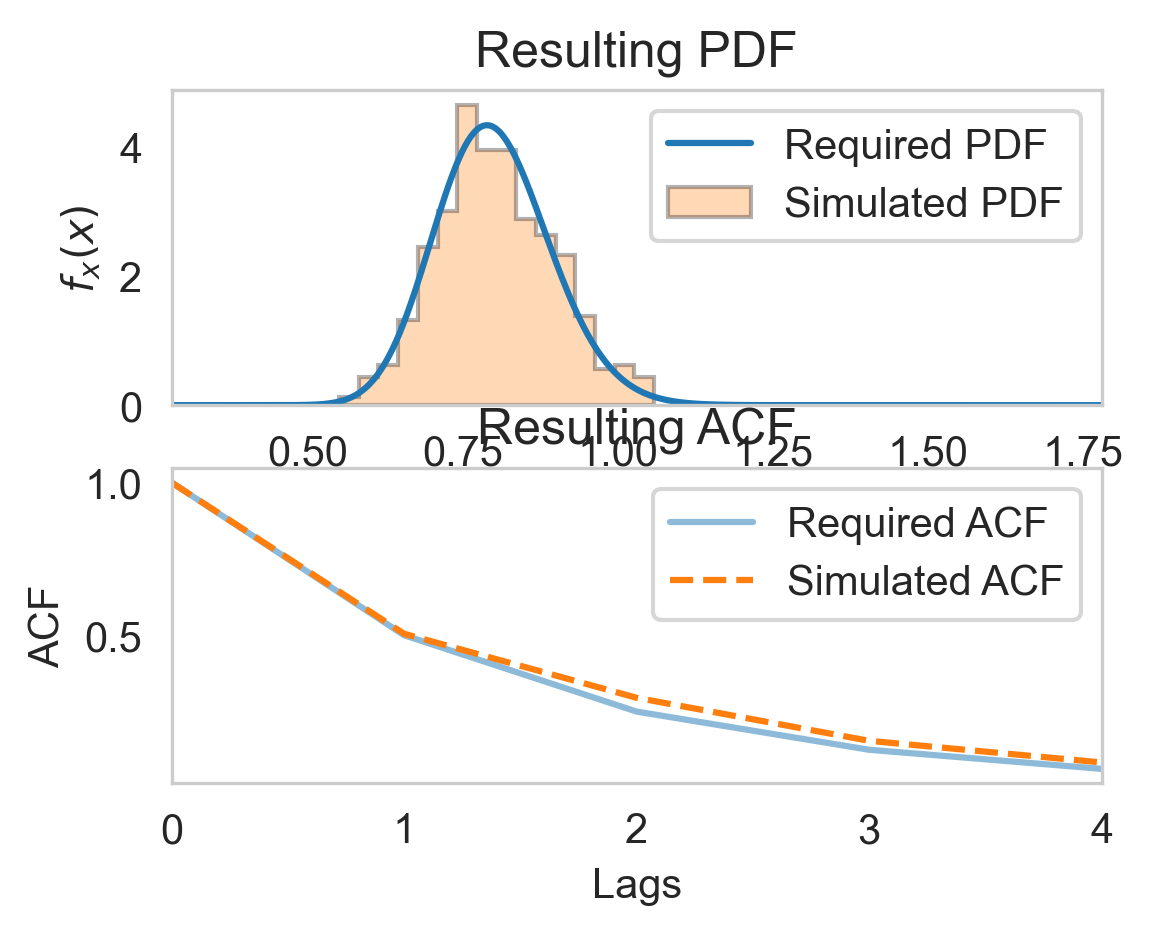

[0.82605789 0.83455659 0.89466178 0.87706621 0.8254443  0.84204751
 0.80973618 0.87345193 0.86049812 0.70697066 0.70754712 0.89939334
 1.00760016 0.83684529 0.87111665 0.90161373 0.8264067  0.81784773
 0.74661735 0.69473261 0.81625712 0.7626077  0.81291433 0.87097284
 0.86105579 0.90916339 0.86904756 0.87893712 0.90459171 0.78764576
 0.69177308 0.78206041 0.87321642 0.81229132 0.77865649 0.7793243
 0.84226214 0.95584143 0.88872234 0.7524137  0.84808915 0.89227534
 0.84870853 0.80419624 0.80572617 0.70633331 0.74565146 0.72102908
 0.85290038 0.91356873 0.89575972 0.82975672 0.89578908 0.90503248
 0.87746708 0.85676288 0.73187589 0.73755887 0.55013712 0.60826548
 0.6872333  0.83051962 0.77876751 0.88598028 0.93501858 1.03059
 0.84343076 0.78810887 0.73027356 0.74430368 0.69441943 0.94381689
 0.79434481 0.87875834 0.79205186 0.88633337 0.84994515 0.79716976
 0.79806925 0.60142762 0.55933975 0.678721   0.70014642 0.68062293
 0.85633306 0.85023919 0.76753879 0.68961505 0.61447314 0.66305199

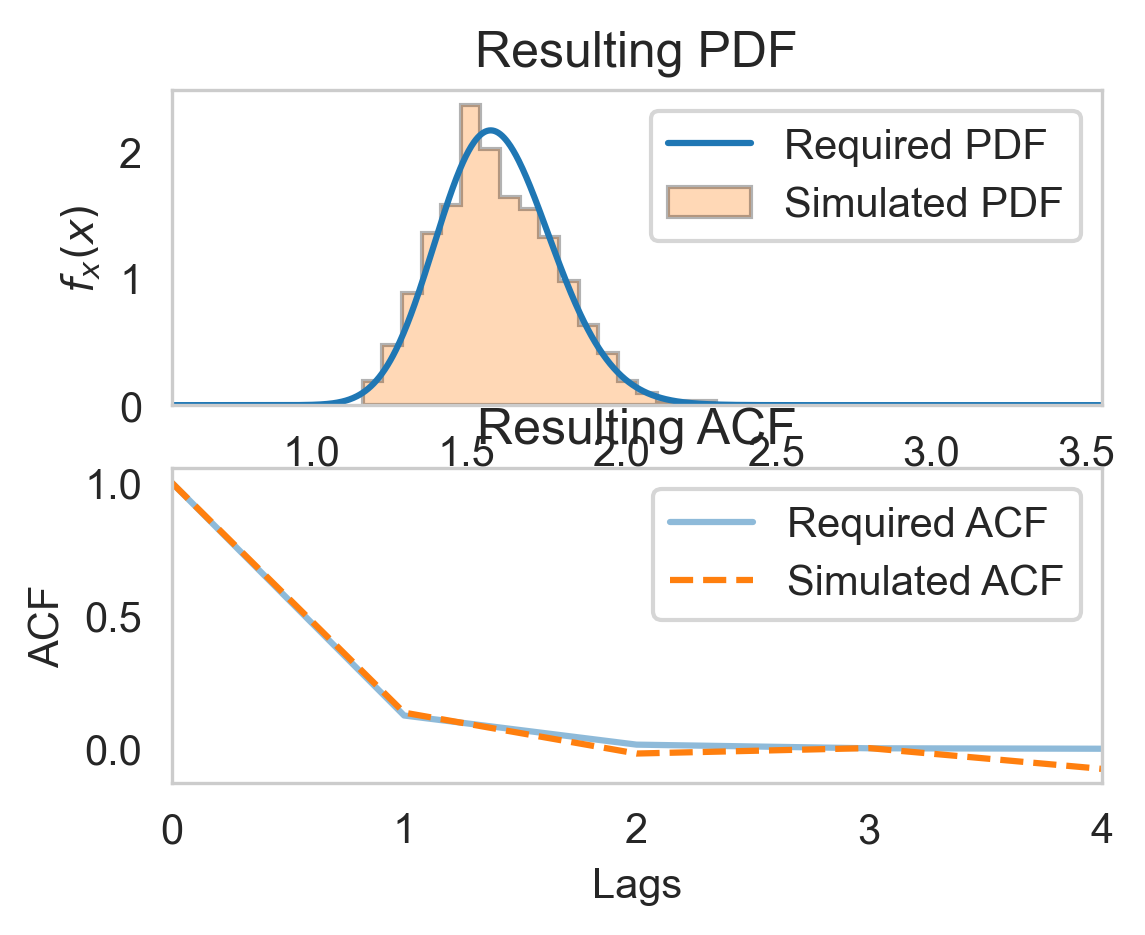

[1.58130234 1.66101635 1.6822896  1.84542341 1.88758597 1.39146173
 1.51500668 1.33783066 1.507516   1.25362985 1.98939729 1.90707568
 1.22636217 1.35571746 1.45981266 1.56040819 1.67575166 1.51711866
 1.24000982 1.60173376 1.49761486 1.59881534 1.77805414 1.61559009
 1.2996866  1.70781191 1.31408486 1.74162505 1.4227473  1.41874961
 1.63246917 1.58870123 1.65215712 1.3977853  1.57500735 1.83935339
 1.58403841 1.55355746 1.79570245 1.70104064 1.74753278 1.91916037
 1.93542607 1.58102465 1.44523754 1.68350893 1.58457399 1.71490289
 1.60810002 1.59198638 1.83686152 1.5403367  1.3503331  1.52587772
 1.35952047 1.5804274  1.65373732 1.7038295  1.61217718 1.70686116
 1.43129861 1.73470465 1.96469385 1.71702231 1.52719586 1.48935162
 1.72141339 1.68100514 2.01203488 1.26106644 1.58901781 1.57262544
 1.3823329  1.65854342 1.5096899  1.65542969 1.9263855  1.33761506
 1.56187387 1.56555865 1.51199884 1.35797899 1.60963022 1.83506873
 1.74620275 1.55506574 1.60748758 1.5094401  1.58917778 1.5918

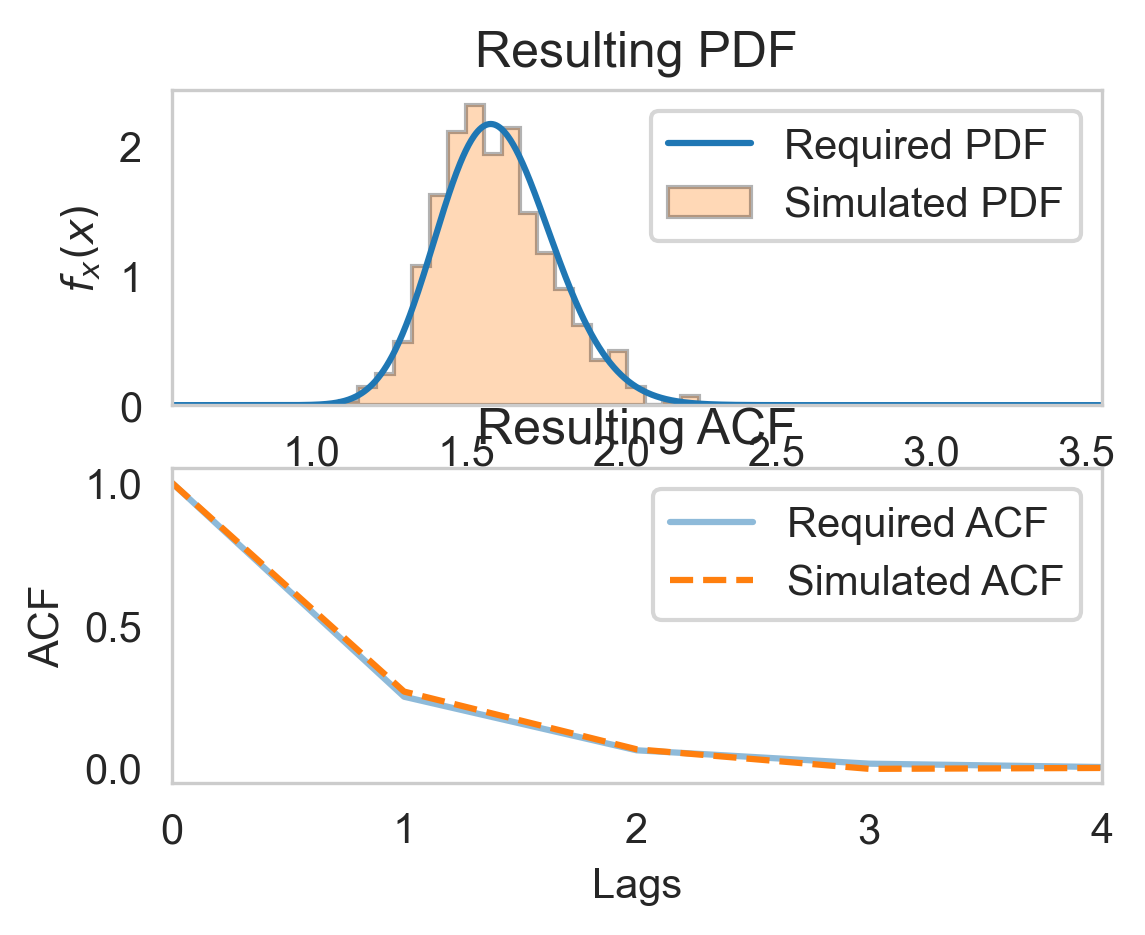

[1.58694363 1.5121953  1.84773866 1.5254098  1.67889664 1.76829917
 1.81237936 1.32622299 1.39683472 1.5117267  1.38266126 1.65076939
 1.4269543  1.25817702 1.43594721 1.50204272 1.49424795 1.72466995
 1.95174497 1.88251384 1.69693069 1.97195794 1.63610396 1.42166786
 1.2396396  1.44396402 1.5810539  1.58633954 1.76028463 1.8078463
 1.98694109 1.587208   1.71391969 1.62211368 1.47146041 1.51609425
 1.68290079 1.66989037 1.34894782 1.81251921 1.48555963 1.563336
 1.65730194 1.58951328 1.61018389 1.51561631 1.45462737 1.56005047
 1.44096881 1.93116185 1.7860205  1.63901349 1.77172798 1.71378162
 1.60030366 1.58242466 1.64683509 1.53167974 1.63785821 1.47305539
 1.64281045 1.19733375 1.61503863 1.69085115 1.4938461  1.31041706
 1.29263183 1.48056086 1.67305855 1.89827058 1.87814966 1.77985482
 1.35962128 1.30530713 1.56370929 1.43654692 1.50585419 1.25426963
 1.70336937 1.68035974 1.62759409 1.64509606 1.74612071 1.56066728
 1.69413178 1.40090534 1.43224746 1.44461264 1.68451493 1.4431284

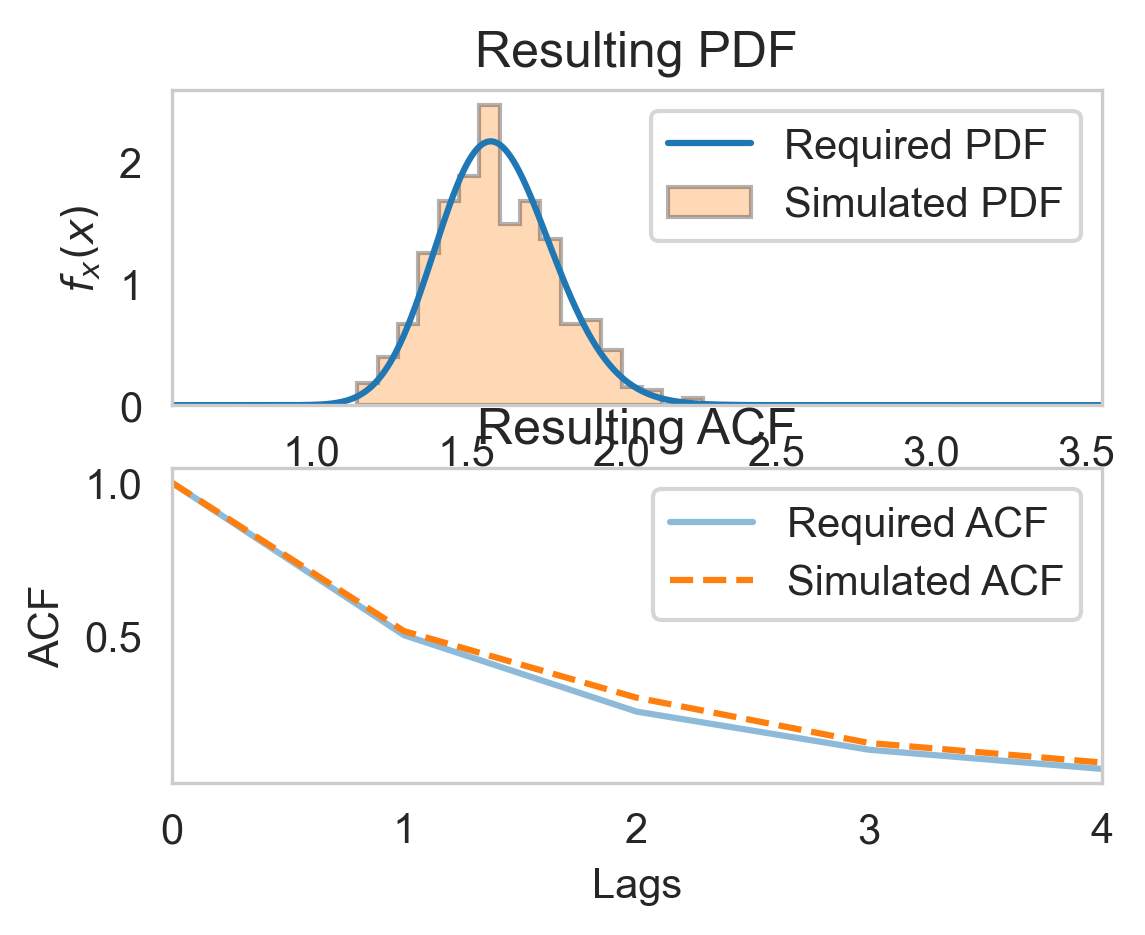

[1.557042   1.64223489 1.53812576 1.68231999 1.50971754 1.64674436
 1.62571807 1.83968969 1.60189089 1.68944505 1.66470473 1.4570052
 1.57156779 1.78879113 1.36353229 1.38830212 1.42038317 1.39030925
 1.77032203 1.9496896  1.4511512  1.68075575 1.44916812 1.76814249
 1.41711791 1.40158017 1.73619728 1.77461229 1.90483656 1.88498522
 1.59191994 1.53991932 1.38781119 1.42964077 1.43008554 1.42354542
 1.41739666 1.24020374 1.41253124 1.4637492  1.71265683 1.80160257
 1.92162065 1.90304939 1.77423451 1.5724149  1.60275375 1.51959575
 1.68352123 1.32674898 1.426697   1.43466549 1.26471677 1.43040816
 1.7173694  1.60523561 1.60090256 1.95102844 1.73367846 1.78957904
 1.58259478 1.41420916 1.57058152 1.571917   1.91760963 1.96329672
 1.9716676  2.02794553 1.62892951 1.55779158 1.71145177 1.48668798
 1.575819   1.53909155 1.70005387 1.84367057 1.44599469 1.32098085
 1.19462126 1.38136038 1.25033726 1.3284062  1.53993309 1.37961308
 1.50259364 1.29805731 1.58563052 1.87492667 1.57910917 1.59647

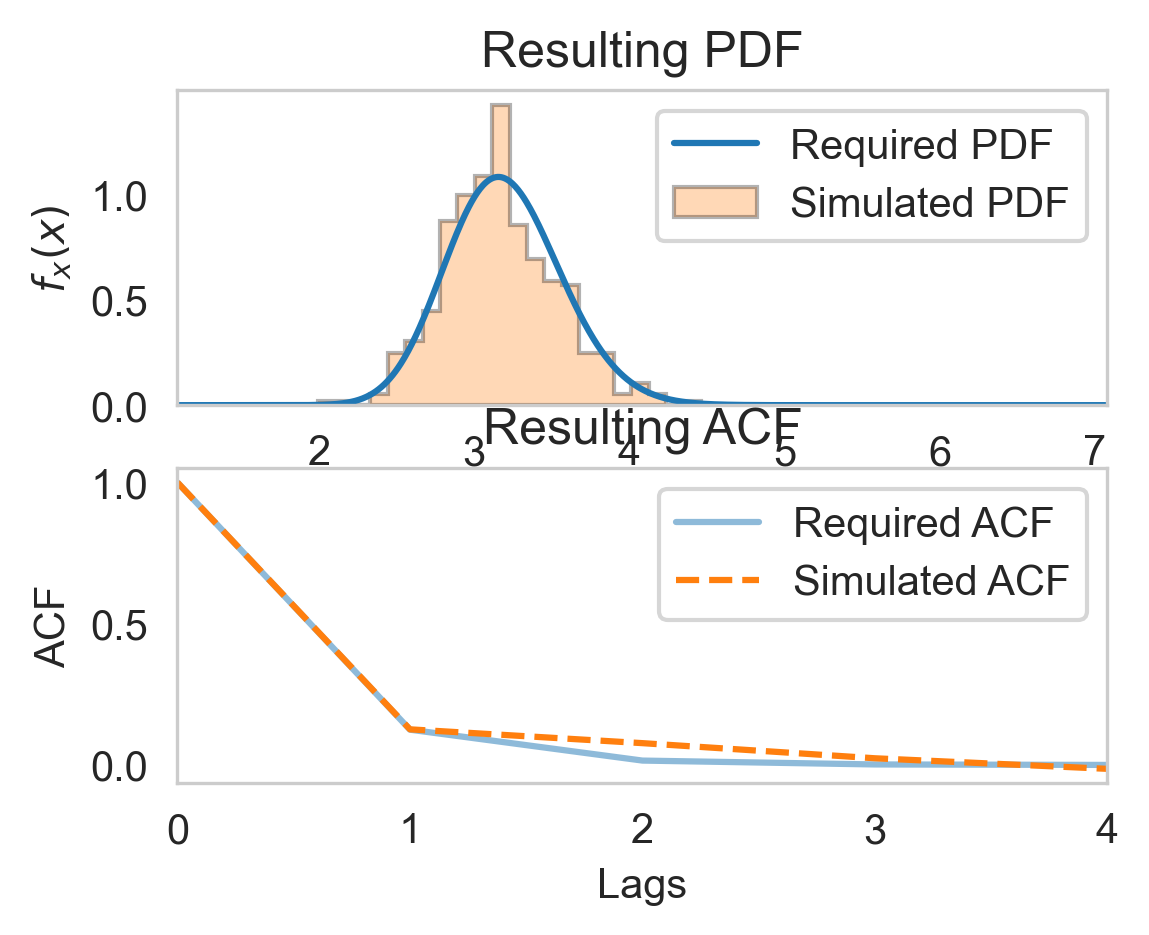

[3.18432084 3.17481306 3.30815032 3.22131698 3.38928096 3.19923995
 2.94258726 3.07632654 3.36424845 3.46943484 2.72189281 2.88651292
 4.09214602 2.84611214 2.9333055  2.94223059 3.53245351 3.50340694
 3.65258455 3.35373643 2.90950813 3.01892367 3.43355087 3.32195059
 2.9201434  3.22940706 2.85650694 3.40996501 3.79711351 2.82637559
 3.64762266 3.59546376 3.21709753 2.85093875 2.89436488 3.14957647
 3.18951438 3.76097312 3.10684743 3.5973538  2.9773735  2.61881022
 3.1036946  3.24664294 2.98191125 3.31407183 3.18661781 3.16021827
 2.6700082  3.18047467 3.34793059 3.29797458 3.66555522 2.95875218
 2.95364844 3.20903268 3.02011716 3.23347846 2.70481968 2.58631119
 3.20145895 3.12117258 3.29613169 3.70619358 3.65299106 2.95251491
 3.59777179 3.01335107 2.74324812 2.57422725 3.21533188 2.62342177
 2.85608058 3.07406122 3.09392091 2.68380745 3.09850059 2.75631489
 3.45202427 3.3290979  2.9564266  3.13669282 3.42096385 2.7141771
 3.11483826 3.12593524 3.71921974 3.56713888 3.23506183 2.93139

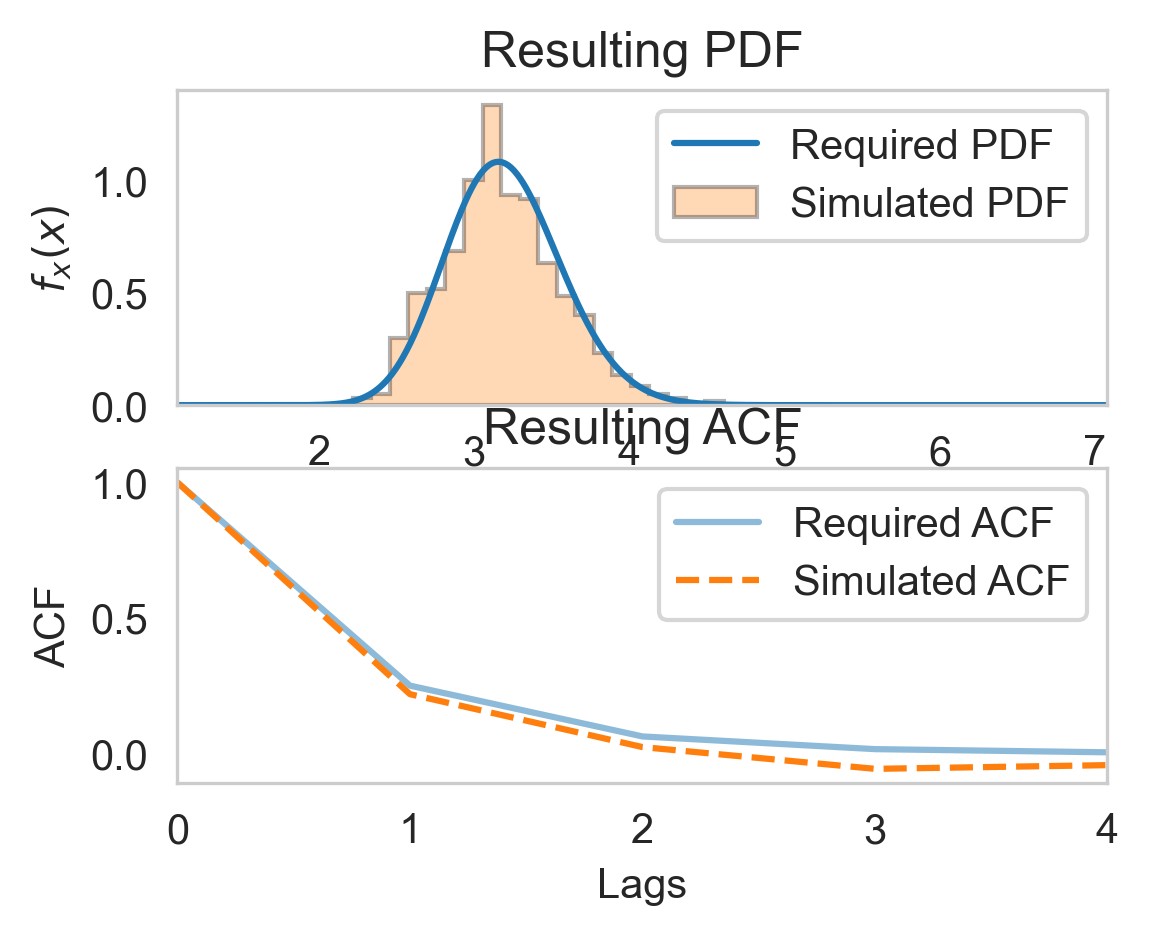

[3.08284712 3.10521382 3.58068142 2.74246635 2.96431284 2.88170917
 3.08133959 3.27392828 3.37263665 2.87221826 3.45302045 2.97826178
 2.62967669 2.93780833 3.13817396 3.86450964 2.95418821 2.64857284
 2.84417163 3.28827664 2.95169163 3.50324935 3.09351068 2.54978793
 2.77487709 3.07164712 3.48548659 3.1985131  2.72631771 3.03020296
 2.78399189 3.36121247 3.00857682 3.01636878 3.42863613 3.7052021
 3.30098796 2.64962805 3.14932324 2.90196926 2.91969646 2.95095051
 2.64496376 2.7634337  3.65413302 3.17708616 3.06849646 2.99693538
 3.92808317 3.57894877 3.8496094  3.30164227 3.16348145 3.29241421
 3.17432506 3.51299954 3.84159071 3.04433568 2.45484546 3.07152688
 3.1023538  2.89963597 3.67133296 3.030857   3.41006188 3.17261851
 2.67011423 3.07076702 2.8315275  3.02998811 3.24926296 3.35305414
 2.74088026 3.59696425 3.52921401 2.89428845 3.72016725 3.64772076
 3.31186297 2.99735231 3.31529176 2.8267706  2.99950992 3.03512596
 3.52254868 3.15869041 2.9921515  3.10822704 2.78524582 3.40517

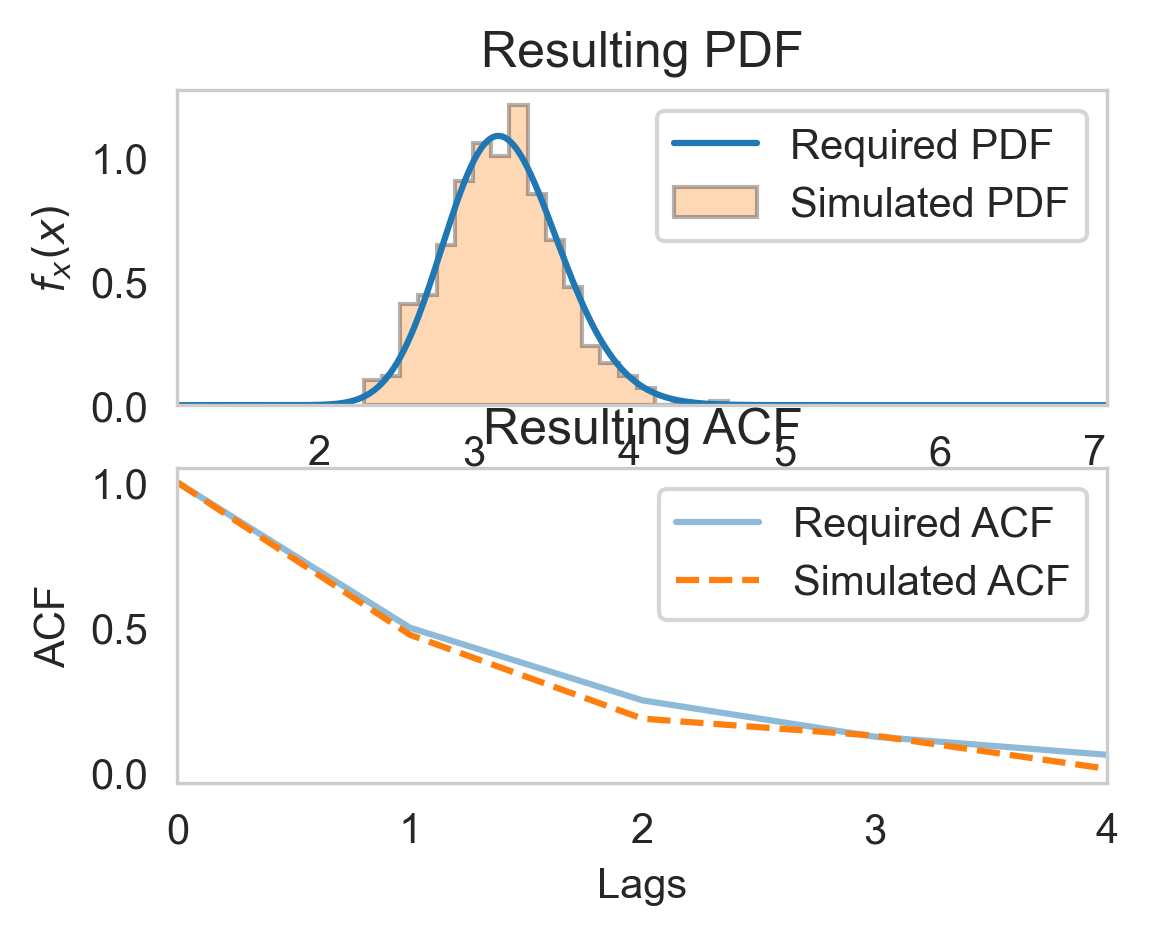

[3.14937734 3.20800611 2.97098944 2.6790778  2.76057512 2.83034875
 2.49755495 2.81393235 2.74863816 3.06692458 3.25769173 3.05519477
 3.29672977 3.21485861 2.7864123  3.00244832 2.90640751 2.96244156
 3.09674223 3.26475979 3.10477981 3.33132802 3.38107423 3.01645405
 2.78591789 2.59541089 2.91302663 3.42049134 3.10109708 3.57090758
 3.91585877 3.39018808 3.6073795  3.27990144 3.33836314 3.30715976
 3.31011005 3.35909574 2.71352462 3.0582464  3.38312074 3.33131033
 3.54974128 3.03718219 2.84365613 3.24564279 4.13469907 3.24309784
 3.60763124 4.63597204 2.76558258 3.04204297 3.30316895 2.56237422
 2.85322256 3.06337099 3.32757792 3.01118516 3.31292037 3.33841375
 3.47208743 3.77326423 3.51447267 3.2334017  3.36245044 3.01067338
 3.369369   3.5172985  3.04821878 2.5704224  2.8610763  3.3233073
 3.45430272 3.6148823  3.7899137  3.86876399 3.93986192 3.59139348
 3.71221933 3.1123951  3.46749996 3.81760789 3.68734485 3.67963733
 3.28801082 2.32269    2.80375074 3.24043429 3.30481479 2.57788

In [62]:
from itertools import product as it_prod

def estimate_std(mean: float, jitter: float) -> float:
    samples = np.empty(1_000_000)
    for i in range(samples.size):
        samples[i] = mean + ((np.random.random() * 2 * jitter) - jitter)

    return samples.std()

acf_50 = 1 / (2 ** np.arange(5))  # 0.5 corr
acf_25 = 1 / (4 ** np.arange(5))
acf_12 = 1 / (8 ** np.arange(5))

mean_jitter = (
    (0.10, 0.02),
    (0.20, 0.04),
    (0.40, 0.08),
    (0.80, 0.16),
    (1.60, 0.32),
    (3.20, 0.64),
)

target_mean_var_s = [(mean, estimate_std(mean, jitter)**2) for mean, jitter in mean_jitter]
loc = 0.042

for (mean, var), (acf, acf_name) in it_prod(target_mean_var_s, ((acf_12, "acf12"), (acf_25, "acf25"), (acf_50, "acf50"))):    
    dist, _, _ = gamma_with_params(loc, mean, var)
    print(f"Mean {mean:0.02f} Var {var:0.02f} ACF {acf_name}")
    seq = gen_corr_sequence(
        dist_obj=dist,
        L=500,
        target_acf=acf,
        debug=True,
    )
    print(seq)
